David Davó Laviña & Ela Katherine Shepherd Arévalo

# Grupo 3, Práctica 2, Parte 1, Apartado A:

In [ ]:
import numpy as np
import numpy.ma as ma
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.model_selection

# Esto es un comando de la terminal, en el que nos descargamos el fichero
# al "sistema de ficheros" de la máquina virtual de colab
# si usamos una librería como pandas que acepte directamente una URL, mejor
# Resulta que gitlab cambió sus servidores hace poco y no acepta el user-agent
# de pandas, y pandas no te deja cambiarlo así que...

![[ ! -f 'yelp_labelled.txt' ]] && wget https://gitlab.com/daviddavo/IA2/-/raw/master/Practica2/yelp_labelled.txt

df = pd.read_csv('yelp_labelled.txt', sep='\t', names=['review', 'valoration'])
df.head()

,review,valoration
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


Vamos a dividir los datos en dos conjuntos, uno para entrenamiento de los clasificadores (75% del conjunto de los datos), y otro para test (25%). Establecemos una semilla fija para que los resultados del *Notebook* sean reproducibles.


In [ ]:
np.random.seed(0b101010)

train, test = sklearn.model_selection.train_test_split(df, train_size=.75)
train

,review,valoration
82,The turkey and roast beef were bland.,0
991,Spend your money and time some place else.,0
789,"Great atmosphere, friendly and fast service.",1
894,If you stay in Vegas you must get breakfast he...,1
398,Service is perfect and the family atmosphere i...,1
...,...,...
106,"The food was delicious, our bartender was atte...",1
270,The Veggitarian platter is out of this world!,1
860,"This place is pretty good, nice little vibe in...",1
435,It was a huge awkward 1.5lb piece of cow that ...,0


In [ ]:
test

,review,valoration
521,If you haven't gone here GO NOW!,1
737,Try them in the airport to experience some tas...,1
740,The restaurant is very clean and has a family ...,1
660,"I personally love the hummus, pita, baklava, f...",1
411,"Come hungry, leave happy and stuffed!",1
...,...,...
109,Sooooo good!!,1
430,I never come again.,0
77,The sweet potato fries were very good and seas...,1
84,The pan cakes everyone are raving about taste ...,0


Ahora representaremos de 4 maneras distintas la bolsa de palabras, cambiando los valores de los parámetros de CountVectorizer:

*   binary = true, ngram_range = (1,1)
*   binary = true, ngram_range = (1,2)
*   tf/idf, ngram_range = (1,1)
*   tf/idf, ngram_range = (1,2)

Probaremos varios clasificadores Naive Bayes para ver como se desarrollan en la práctica. Pero, cuando no usamos TF/IDF, la bolsa de palabras será binarizada, pues no proporciona mucha información que aparezca múltiples veces la misma palabra positiva en el texto. Es decir, si en el texto menciona una cosa buena, es muy probable que mencione otras cosas buenas («good food», «good service», etc.), por lo que no es muy relevante contar el número de veces que menciona, por ejemplo, «good».

En cuanto al vectorizador, lo hemos modificado un poco para que acepte palabras con un apóstrofe en medio. Así podemos diferenciar entre «*we'll*» y «*we've*»


In [ ]:
# Vectorizer parameters to be always used
default_vectorizer_params = {
    "stop_words":'english',
    # Ahora reconocemos palabras como we'll don't, etc y diferenciamos entre we'll y we've
    "token_pattern":r'\b\w\w+\'?\w*\b'  
}

## Clasificadores Naive Bayes

### Código del clasificador Naive Bayes Multinomial Binarizado

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

def getTrainTestBernoulliNB(vdtrain, vdtest):
    """Bernoulli Naive Bayes"""
    classifier = BernoulliNB()
    classifier.fit(vdtrain, train.valoration)
    return classifier.predict(vdtrain), classifier.predict(vdtest)

def getTrainTestMultinomialNB(vdtrain, vdtest):
    """Multinomial Naive Bayes"""
    classifier = MultinomialNB()
    classifier.fit(vdtrain, train.valoration)
    return classifier.predict(vdtrain), classifier.predict(vdtest)

### Código del clasificador Naive Bayes Gausiano

Como el clasificador no acepta matrices dispersas, y la matriz de datos es muy grande, entrenamos el clasificador por lotes. De no ser posible ejecutarlo en un ordenador, hay que modificar el `chunk_size`.

In [ ]:
from sklearn.naive_bayes import GaussianNB

def write_terms (names, data, vector_data, index):
    mask=vector_data[index,:]>0
    terms = ma.array(names, mask = ~(mask[0].toarray()))
    if data:
        print('Message', index, ':', data[index])

    print('Message', index, 'vectorized:', terms.compressed())

def getTrainTestGausianNB(vdtrain, vdtest):
    """Gaussian Naive Bayes"""

    # Ahora clasificadores
    classifier = GaussianNB()
    chunk_size = 1000
    num_rows = len(train.valoration)

    for i in range(0, ((num_rows+chunk_size-1) // chunk_size)):
        train_chunk = vdtrain[i*chunk_size : (i+1)*chunk_size,:].toarray()
        target_chunk = train.valoration[i*chunk_size : (i+1)*chunk_size]
        classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train.valoration))

    train_predictions = np.zeros_like(train.valoration)
    test_predictions = np.zeros_like(test.valoration)

    # num_rows = len(train.valoration)
    for i in range(0, ((num_rows+chunk_size-1) // chunk_size)):
        train_chunk = vdtrain[i*chunk_size : (i+1)*chunk_size,:].toarray()
        train_predictions[i*chunk_size : (i+1)*chunk_size] = classifier.predict(train_chunk)

    num_rows=len(test.valoration)
    for i in range(0, ((num_rows+chunk_size-1)//chunk_size)):
        test_chunk = vdtest[i*chunk_size : (i+1)*chunk_size,:].toarray()
        test_predictions[i*chunk_size : (i+1)*chunk_size] = classifier.predict(test_chunk)
    
    return train_predictions, test_predictions

## Clasificador Árbol de decisión

En primer lugar, vamos a tratar de optimizar y maximizar la precisión del árbol de decisión. Para ello, visualizaremos la curva de aprendizaje de los conjuntos dados de train y test, modificando el parámetro max_leaf_nodes. Debido a la cantidad de variables, es muy dificil que haya varias *reviews* que caigan exactamente en la misma hoja, por lo que no parece una buena opción modificar el número mínimo de elementos para crear una hoja (`min_samples_leaf`), este efecto será más pronunciado con bigramas, pues habrá más dispersión entre las variables. Al ser un arbol binario, `max_leaf_nodes` y `max_depth` estarán relacionadas, pero al establecer una profundidad máxima "aplanará" el árbol (intentará mostrar la información en la poca altura que tenga disponible), mientras que poner un numero máximo de nodos hoja sin limitar la profundidad lo "estirará" (intentará usar el mayor número posible de nodos no-hoja).

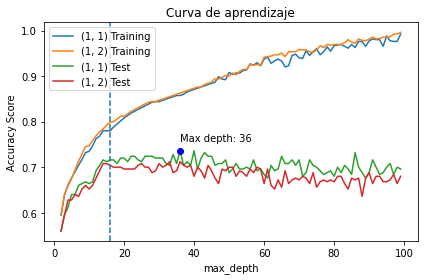

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

ngrams = [(1,1), (1,2)]
# Creamos un par de diccionarios con clave ngrama y valor una lista vacía
train_accuracy = {x:[] for x in ngrams}
test_accuracy = {x:[] for x in ngrams}

max_range = range(2,100)
for ngram, md in it.product(ngrams, max_range): 

    vectorizer = TfidfVectorizer(binary='false', ngram_range=ngram, **default_vectorizer_params)

    vdtrain = vectorizer.fit_transform(train.review)
    vdtest = vectorizer.transform(test.review)

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md)
    clf.fit(vdtrain, train.valoration)
    train_predictions = clf.predict(vdtrain)
    test_predictions = clf.predict(vdtest)
    
    train_accuracy[ngram].append(np.mean(train_predictions == train.valoration))
    test_accuracy[ngram].append(np.mean(test_predictions == test.valoration))

# Draw lines
for ngram, arr in train_accuracy.items():
    plt.plot(max_range, arr, label=f"{ngram} Training")

for ngram, arr in test_accuracy.items():
    plt.plot(max_range, arr, label=f"{ngram} Test")
    
testmax = 0
for ngram, arr in test_accuracy.items():
    if (max(arr)) > testmax:
        testmax = max(arr)
        depthmax = max_range[arr.index(testmax)]

plt.plot(depthmax, testmax, 'bo')
plt.annotate("Max depth: %d" % (int(depthmax)), (depthmax, testmax), xytext=(0, 10), textcoords="offset pixels")
plt.axvline(16, ls="--")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("max_depth"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()

plt.show()

Aunque el máximo se produzca en un número muy elevado, parece ser un máximo local que no es replicable y que, si cogemos otro conjunto de train/test, será distinto. Por ello hemos elegido como valor máximo del parámetro `max_depth` el 16, que parece ser el punto de inflexión en el que la curva de aprendizaje deja de subir. Aun así, no parece haber demasiado overfitting.

In [ ]:
MAX_DEPTH = 16

def getTrainTestDecissionTreeDefault(vdtrain, vdtest):
    """Árbol de Decisión"""
    classifier = DecisionTreeClassifier(criterion="entropy")
    classifier.fit(vdtrain, train.valoration)
    return classifier.predict(vdtrain), classifier.predict(vdtest)

def getTrainTestDecissionTreeOptimized(vdtrain, vdtest):
    """Árbol de Decisión (Optimizado)"""
    classifier = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
    classifier.fit(vdtrain, train.valoration)
    return classifier.predict(vdtrain), classifier.predict(vdtest)

## Código de la comparación de clasificadores

>>> ngram: (1, 1), len: 1537, TF/IDF: False, classifier: Bernoulli Naive Bayes
>>> ngram: (1, 1), len: 1537, TF/IDF: True, classifier: Bernoulli Naive Bayes
>>> ngram: (1, 1), len: 1537, TF/IDF: False, classifier: Multinomial Naive Bayes
>>> ngram: (1, 1), len: 1537, TF/IDF: True, classifier: Multinomial Naive Bayes
>>> ngram: (1, 1), len: 1537, TF/IDF: True, classifier: Gaussian Naive Bayes
>>> ngram: (1, 1), len: 1537, TF/IDF: False, classifier: Árbol de Decisión
>>> ngram: (1, 1), len: 1537, TF/IDF: True, classifier: Árbol de Decisión
>>> ngram: (1, 1), len: 1537, TF/IDF: False, classifier: Árbol de Decisión (Optimizado)
>>> ngram: (1, 1), len: 1537, TF/IDF: True, classifier: Árbol de Decisión (Optimizado)
>>> ngram: (1, 2), len: 4429, TF/IDF: False, classifier: Bernoulli Naive Bayes
>>> ngram: (1, 2), len: 4429, TF/IDF: True, classifier: Bernoulli Naive Bayes
>>> ngram: (1, 2), len: 4429, TF/IDF: False, classifier: Multinomial Naive Bayes
>>> ngram: (1, 2), len: 4429, TF/IDF: True,

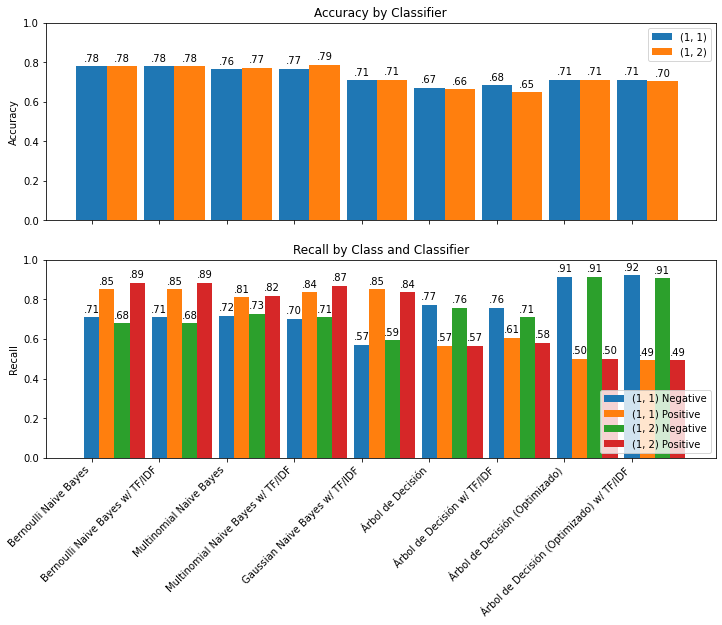

In [ ]:
from sklearn.metrics import classification_report

ngrams = [(1,1), (1,2)]
classifier_functions = [
    (False, getTrainTestBernoulliNB),            # No TF/IDF, clasificador Bernoulli
    (True,  getTrainTestBernoulliNB),            # Sí TF/IDF, clasificador Bernoulli
    (False, getTrainTestMultinomialNB),          # No TF/IDF, clasificador Multinomial
    (True,  getTrainTestMultinomialNB),          # Sí TF/IDF, clasificador Multinomial
    (True,  getTrainTestGausianNB),              # Sí TF/IDF, clasificador Gausiano
    (False, getTrainTestDecissionTreeDefault),   # No TF/IDF, clasificador Árbol de Decisión
    (True,  getTrainTestDecissionTreeDefault),   # Sí TF/IDF, clasificador Árbol de Decisión
    (False, getTrainTestDecissionTreeOptimized), # No TF/IDF, clasificador Árbol de Decisión Optimizado
    (True,  getTrainTestDecissionTreeOptimized)  # Sí TF/IDF, clasificador Árbol de Decisión Optimizado
]

def bucleGuay(ngrams, classifier_functions):
    res = {}
    res["data"] = {n:{"train":[], "test":[]} for n in ngrams}
    res["tfidf"], res["labels"] = [list(l) for l in zip(*[(tfidf, cf.__doc__) for tfidf, cf in classifier_functions])]
    for ngram, (tfidf, cf) in it.product(ngrams, classifier_functions):
        if tfidf:
            # Menor tiempo de ejecución y mayor legibilidad que vectorizer + transformer
            vectorizer = TfidfVectorizer(binary='false', ngram_range=ngram, **default_vectorizer_params)
        else:
            vectorizer = CountVectorizer(binary='true', ngram_range=ngram, **default_vectorizer_params)

        vdtrain = vectorizer.fit_transform(train.review)
        vdtest = vectorizer.transform(test.review)
        names = vectorizer.get_feature_names()
        print(f'>>> ngram: {ngram}, len: {len(names)}, TF/IDF: {tfidf}, classifier: {cf.__doc__}')
        
        train_predictions, test_predictions = cf(vdtrain, vdtest)

        # print(classification_report(test.valoration, test_predictions, target_names=["Negative", "Positive"]))
        cr_train = classification_report(train.valoration, train_predictions, target_names=["Negative", "Positive"], output_dict=True)
        cr_test = classification_report(test.valoration, test_predictions, target_names=["Negative", "Positive"], output_dict=True)

        res["data"][ngram]["train"].append(cr_train)
        res["data"][ngram]["test"].append(cr_test)
    return res

# Based on https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def plotClassifiersAccuracy(classifiers_report, show_recall=False):
    x = np.arange(len(classifiers_report["labels"]))

    if show_recall:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex='col', figsize=(12,8))
    else:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex='col', figsize=(12,4))

    ax1.set_title("Accuracy by Classifier")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0,1])
    ax1.set_xticks(x)

    if show_recall:
        ax2.set_title("Recall by Class and Classifier")
        ax2.set_ylabel("Recall")
        ax2.set_ylim([0,1])
        ax2.set_xticks(x)

    total_width = .9
    offset_increment = total_width/(len(classifiers_report["data"]))
    offset = 0
    for ngram, data in classifiers_report["data"].items():
        # Preparing data
        ac = [x["accuracy"] for x in data["test"]]
        acbarcontainer = ax1.bar(x+offset, ac, width=offset_increment, label=str(ngram))
        axs = [(ax1, acbarcontainer)]

        if show_recall:
            recalln = [x["Negative"]["recall"] for x in data["test"]]
            recallp = [x["Positive"]["recall"] for x in data["test"]]
            rnbarcontainer = ax2.bar(x+offset, recalln, width=offset_increment/2, label=str(ngram)+" Negative")
            rpbarcontainer = ax2.bar(x+offset+offset_increment/2, recallp, width=offset_increment/2, label=str(ngram)+ " Positive")
            axs.extend([(ax2, rnbarcontainer), (ax2, rpbarcontainer)])

        for ax,bc in axs:
            for r in bc:
                ax.annotate(f'{r.get_height():.2f}'.lstrip('0'),
                    xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha="center", va="bottom"
                )
        offset += offset_increment

    # The "" is the label for '0'
    ax1.legend()
    xticklabels = [label + (f' w/ TF/IDF' if tfidf else "") for label,tfidf 
        in zip(classifiers_report["labels"], classifiers_report["tfidf"])]

    if show_recall:
        ax2.legend(loc="lower right") # Si no no sen los datos
        ax2.set_xticklabels(xticklabels, rotation=45, ha="right")
    else:
        ax1.set_xticklabels(xticklabels, rotation=45, ha="right")

total_report = bucleGuay(ngrams, classifier_functions)
plotClassifiersAccuracy(total_report, True)

En todos los clasificadores Naive Bayes parece aumentar más de un 1% la precisión cuando pasas de monogramas a bigramas, con la excepción del clasificador de Bernoulli. En los árboles de decisión parece que usar bigramas disminuye la precisión.

Sobre TF/IDF parece aumentar un poco la precisión en el Multinomial y del Árbol de Decisión, mientras que se mantiene igual en el Bernoulli. 

Podríamos pensar que, al clasificar en sólo dos clases y tener una bolsa de palabras binarizada, la distribución de Bernoulli sería una buena opción, pero con una precisón muy cercana a la Multinomial, podemos observar una gran diferencia en el recall. Esto es porque es un clasificador que «asume» que «si algo NO es x, entonces es y», por lo que falla cuando las reviews no tienen un sentimiento muy fuerte. El que tenga mucho más exhaustividad en una clase que en otra nos permitiría usarlo (con otros datos de entrenamiento) para identificar, por ejemplo, *trolls* o *spam* en las reseñas.

Al usar TF/IDF, comenzamos a tratar con datos continuos, por lo que es normal pensar que usar el clasificador Gausiano sería una buena opción, pero este clasificador asume una distribución normal, que puede no darse en nuestros datos, haciendo que en la práctica sea mejor usar otro clasificador. También podemos observar una gran diferencia entre la exhaustividad de ambas clases, con tan sólo un 57% de *recall* identificando las reviews negativas usando monogramas.

Sobre el árbol de decisión, podemos observar en el gráfico con la exhaustividad en las clases que es el peor clasificador identificando las reviews positivas, pero el mejor con las negativas. Esto es porque hemos intentado optimizar simplemente la tasa de aciertos, sin tener en cuenta la exhaustividad, podríamos evitarlo tratando de optimizar respecto a la métrica F1 (media de precisión y exhaustividad). 

El clasificador Naive Bayes con mejor tasa de aciertos parece ser el Naive Bayes Multinomial con TF/IDF y bigramas (es decir, añadir complejidad). Sobre el árbol de decisión optimizado, usar o no usar TF/IDF y usar monogramas o bigramas parece no mejorar demasiado los resultados, por lo que escogeremos para analizar el árbol de decisión más simple, con monogramas y sin TF/IDF.

## Mejor árbol de decisión

Tomaremos el árbol de decisón con la representación que usa monogramas y sin tf/idf

In [ ]:
vectorizer = CountVectorizer(binary='true', ngram_range=(1,1), **default_vectorizer_params)

vd = vectorizer.fit_transform(df.review)
tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
tree_classifier.fit(vd, df.valoration)
feature_names = vectorizer.get_feature_names()
    
top25 = np.argsort(tree_classifier.feature_importances_)[-25:]
bot25 = np.argsort(tree_classifier.feature_importances_)[:25]
print("Top 25 features in the tree")
print(" / ".join(feature_names[j] for j in top25[::-1]))

Top 25 features in the tree
great / good / delicious / amazing / fantastic / nice / friendly / vegas / awesome / excellent / perfect / loved / love / town / sushi / minutes / bad / service / way / restaurants / quickly / instead / served / like / helpful


De las 25 variables escogidas, 17 podrían clasificarse como buenas (aunque algunas como "like" existen en comentarios negativos: *did not like at all.*), el resto no tienen ningún sentimiento, es decir existe ruido. Estas palabras suelen ser sustantivos, como "bread", porque hay mucha gente hablando tanto de manera positiva como negativamente de ello.

El que no haya casi variables negativas quizás se debe a que las personas cuando describimos algo de manera positiva generalmente usamos un vocabulario reducido. Si observamos las críticas positivas, casi siempre hay algún adjetivo o verbo que casi siempre usaríamos hacia algo que nos gusta: 

*   Food was *great* and so was the serivce!
*   Everything was *good* and tasty!	
*   It was absolutely *amazing*.
*   I *love* their fries and their beans.

Sin embargo, las críticas negativas suelen ser más largas, explicando por qué el establecimiento no era agradable, y aunque a veces se ven claramente palabras de puro sentimiento negativo como "horrible", en muchos de los casos no hay palabras así, y el vocabulario es más extenso, y si separamos las palabras, no podríamos identificar la negatividad:

*   A lady at the table next to us found a live green caterpillar In her salad.
*   The food was barely lukewarm, so it must have been sitting waiting for the server to bring it out to us.
*   not even a "hello, we will be right with you."
*   Definitely a turn off for me & i doubt I'll be back unless someone else is buying.
*   very tough and very short on flavor!
*   Kind of hard to mess up a steak but they did.

También debemos tener en cuenta que, para no ser demasiado "hirientes", pueden escribirse reseñas negativas intentando no ser demasiado duros, usando una negación de una palabra positiva, pero suavizandolo con otras palabras intermedias. Por ejemplo "no estaba demasiado bueno" tiene la palabra "no", pero para relacionar "no" con "bueno" necesitaríamos 4-gramas.

## Mejor Naive Bayes


Por lo que hemos observado en las celdas anteriores, donde hay más tasa de aciertos en ambos grupos es en el Naive Bayes Multinomial con bigramas:


In [ ]:
vectorizer = TfidfVectorizer(binary='false', ngram_range=(1,2), **default_vectorizer_params)
vd = vectorizer.fit_transform(df.review)
nb_classifier = MultinomialNB()
nb_classifier.fit(vd, df.valoration)
feature_names = vectorizer.get_feature_names()

top25 = np.argsort(nb_classifier.feature_log_prob_[1])[-25:]
bot25 = np.argsort(nb_classifier.feature_log_prob_[0])[-25:]
print("Top 25 positive features in Naive Bayes")
print(" / ".join([feature_names[j] for j in top25[::-1]]))
print("Top 25 negative features in Naive Bayes")
print(" / ".join([feature_names[j] for j in bot25[::-1]]))

Top 25 positive features in Naive Bayes
good / great / place / food / service / delicious / amazing / friendly / nice / awesome / love / time / best / really / fantastic / just / restaurant / loved / staff / definitely / vegas / experience / excellent / food good / atmosphere
Top 25 negative features in Naive Bayes
food / service / place / won't / don't / like / good / terrible / bad / worst / think / time / disappointed / going / probably / minutes / wasn't / just / eating / slow / ve / eat / got / came / way


Dentro de las palabras positivas hay mucho menos ruido comparado con el que hay en el conjunto de palabras negativas. Es más, podemos ver palabras como "better" y "good" dentro de las palabras con más presencia en comentarios negativos. 

Volviendo a lo que se comentó en el apartado anterior, hay menos ruido en las palabras positivas porque cuando puntuamos algo de forma positiva lo expresamos de forma muy clara, mientras que cuando lo hacemos de forma negativa describimos más la experiencia, y ahí usamos palabras que como tal no tienen sentimiento negativo. Además, hay algunas palabras que coinciden en ambos grupos pero ninguno es como tal de un conjunto u otro, como por ejemplo "food" o "place", porque hay valoraciones de todo tipo refiriéndose a estos conceptos: 


*   The food, amazing.
*   We got the food and apparently they have never heard of salt and the batter on the fish was chewy.
*   This place has it!
*   Although I very much liked the look and sound of this place, the actual experience was a bit disappointing.

Por último, el que haya palabras que normalmente veríamos como buenas en el conjunto de palabras negativas es porque es mucho más común que describamos algo malo con la negación de algo positivo a que describamos algo bueno con la negación de algo negativo (es más, cuando decimos expresiones como "no está mal" suele ser mostrando indiferencia): 


*   I've had better, not only from dedicated boba tea spots, but even from Jenni Pho.
*   However, my recent experience at this particular location was not so good.





## Conclusiones de la parte A

No sólo es importante la tasa de aciertos en general, si no también la exhaustividad o recall. Además, la representación de texto mediante una bolsa de palabras, aunque simplifica mucho el problema, tiene sus inconvenientes, como vimos en el apartado anterior.

# Grupo 3, Práctica 2, Parte 1, Apartado B:

## Exhaustividad y precisión de los clasificadores

En la parte A ya hicimos un análisis superficial de todos los clasificadores que podríamos usar. A continuación, analizaremos más a fondo el mejor clasificador Naive Bayes (Multinomial con TF/IDF) y el mejor clasificador en árbol (con TF/IDF también).

### Naive Bayes Multinomial

              precision    recall  f1-score   support

    negative       0.85      0.73      0.78       128
    positive       0.75      0.86      0.80       122

    accuracy                           0.79       250
   macro avg       0.80      0.79      0.79       250
weighted avg       0.80      0.79      0.79       250



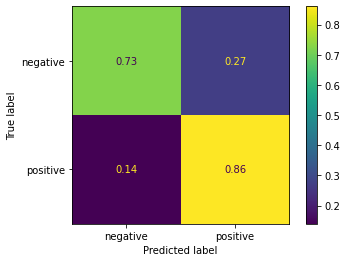

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix

vectorizer = TfidfVectorizer(stop_words='english', binary='false', ngram_range=(1,2))
vdtrain = vectorizer.fit_transform(train.review)
vdtest = vectorizer.transform(test.review)

nb_classifier = MultinomialNB()
nb_classifier.fit(vdtrain, train.valoration)

test_predictions = nb_classifier.predict(vdtest)

tg = ['negative', 'positive']
print(classification_report(test.valoration, test_predictions, target_names=tg))
plot_confusion_matrix(nb_classifier, vdtest, test.valoration, display_labels=tg, normalize='true')

### Árbol de Decisión

              precision    recall  f1-score   support

    negative       0.66      0.91      0.76       128
    positive       0.85      0.50      0.63       122

    accuracy                           0.71       250
   macro avg       0.75      0.71      0.70       250
weighted avg       0.75      0.71      0.70       250



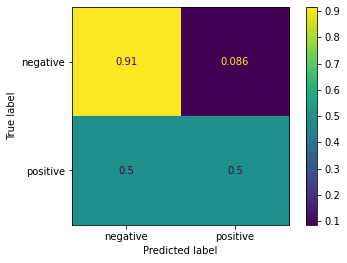

In [ ]:
vectorizer = CountVectorizer(binary='true', ngram_range=(1,1), **default_vectorizer_params)

vd = vectorizer.fit_transform(df.review)
vdtrain = vectorizer.fit_transform(train.review)
tree_vdtest = vectorizer.transform(test.review)

tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
tree_classifier.fit(vdtrain, train.valoration)

tree_test_predictions = tree_classifier.predict(tree_vdtest)

print(classification_report(test.valoration, tree_test_predictions, target_names=tg))
plot_confusion_matrix(tree_classifier, tree_vdtest, test.valoration, display_labels=tg, normalize='true')

Ninguno de los dos clasificadores tiene un comportamiento homogéneo, y tampoco hay un clasificador que sea mejor que el otro en todo. El Naive Bayes parece estar sesgado hacia las reviews positivas, con una diferencia en el recall del 15%. El segundo clasificador, sin embargo, tiene graves problemas clasificando las reviews positivas, pues parece que "lanza una moneda al aire" cada vez que debe clasificar una, ya que tiene tan sólo un 50% de exhaustividad. Sin embargo, tiene menos de un 10% de falsos negativos, por lo que es muy buen clasificador identificando las reviews negativas.

El primer clasificador tiene un accuracy medio mejor que el segundo (0.79 vs 0.71).

El primer clasificador parece tener una ligeramente mayor precisión clasificando los comentarios positivos que los negativos. En cuanto al segundo,aunque la exhaustividad es muy buena identificando comentarios negativos, es muy malo identificando los comentarios positivos, a tal punto de que para los comentarios positivos, la tasa de aciertos es poco mayor que la tasa de fallos. La baja exhaustividad en cuanto a los comentarios positivos baja el F1 a 0.63.

El clasificador del árbol de decisión es capaz de identificar mucho mejor las opiniones negativas, por lo que nos podría servir como auto-moderador de un foro, o para identificar restaurantes especialmente malos, pero si lo que queremos es clasificar correctamente, un clasificador con tan baja exhaustividad en una de sus clases no es muy útil, por lo que recomendaríamos usar el Naive Bayes.

## Árbol de decisión pintado

[Text(2658.705882352941, 3098.52, 'great <= 0.077\nentropy = 1.0\nsamples = 750\nvalue = [372, 378]\nclass = Positive'),
 Text(2461.7647058823527, 2772.36, 'delicious <= 0.109\nentropy = 0.997\nsamples = 696\nvalue = [372, 324]\nclass = Negative'),
 Text(2264.823529411765, 2446.2, 'good <= 0.16\nentropy = 0.993\nsamples = 676\nvalue = [372, 304]\nclass = Negative'),
 Text(1575.5294117647059, 2120.04, 'nice <= 0.114\nentropy = 0.98\nsamples = 615\nvalue = [359, 256]\nclass = Negative'),
 Text(1181.6470588235293, 1793.88, 'amazing <= 0.339\nentropy = 0.972\nsamples = 597\nvalue = [357, 240]\nclass = Negative'),
 Text(984.7058823529412, 1467.72, 'love <= 0.302\nentropy = 0.966\nsamples = 587\nvalue = [357, 230]\nclass = Negative'),
 Text(787.7647058823529, 1141.56, 'awesome <= 0.174\nentropy = 0.959\nsamples = 577\nvalue = [357, 220]\nclass = Negative'),
 Text(590.8235294117646, 815.4000000000001, 'friendly <= 0.277\nentropy = 0.952\nsamples = 568\nvalue = [357, 211]\nclass = Negative'),


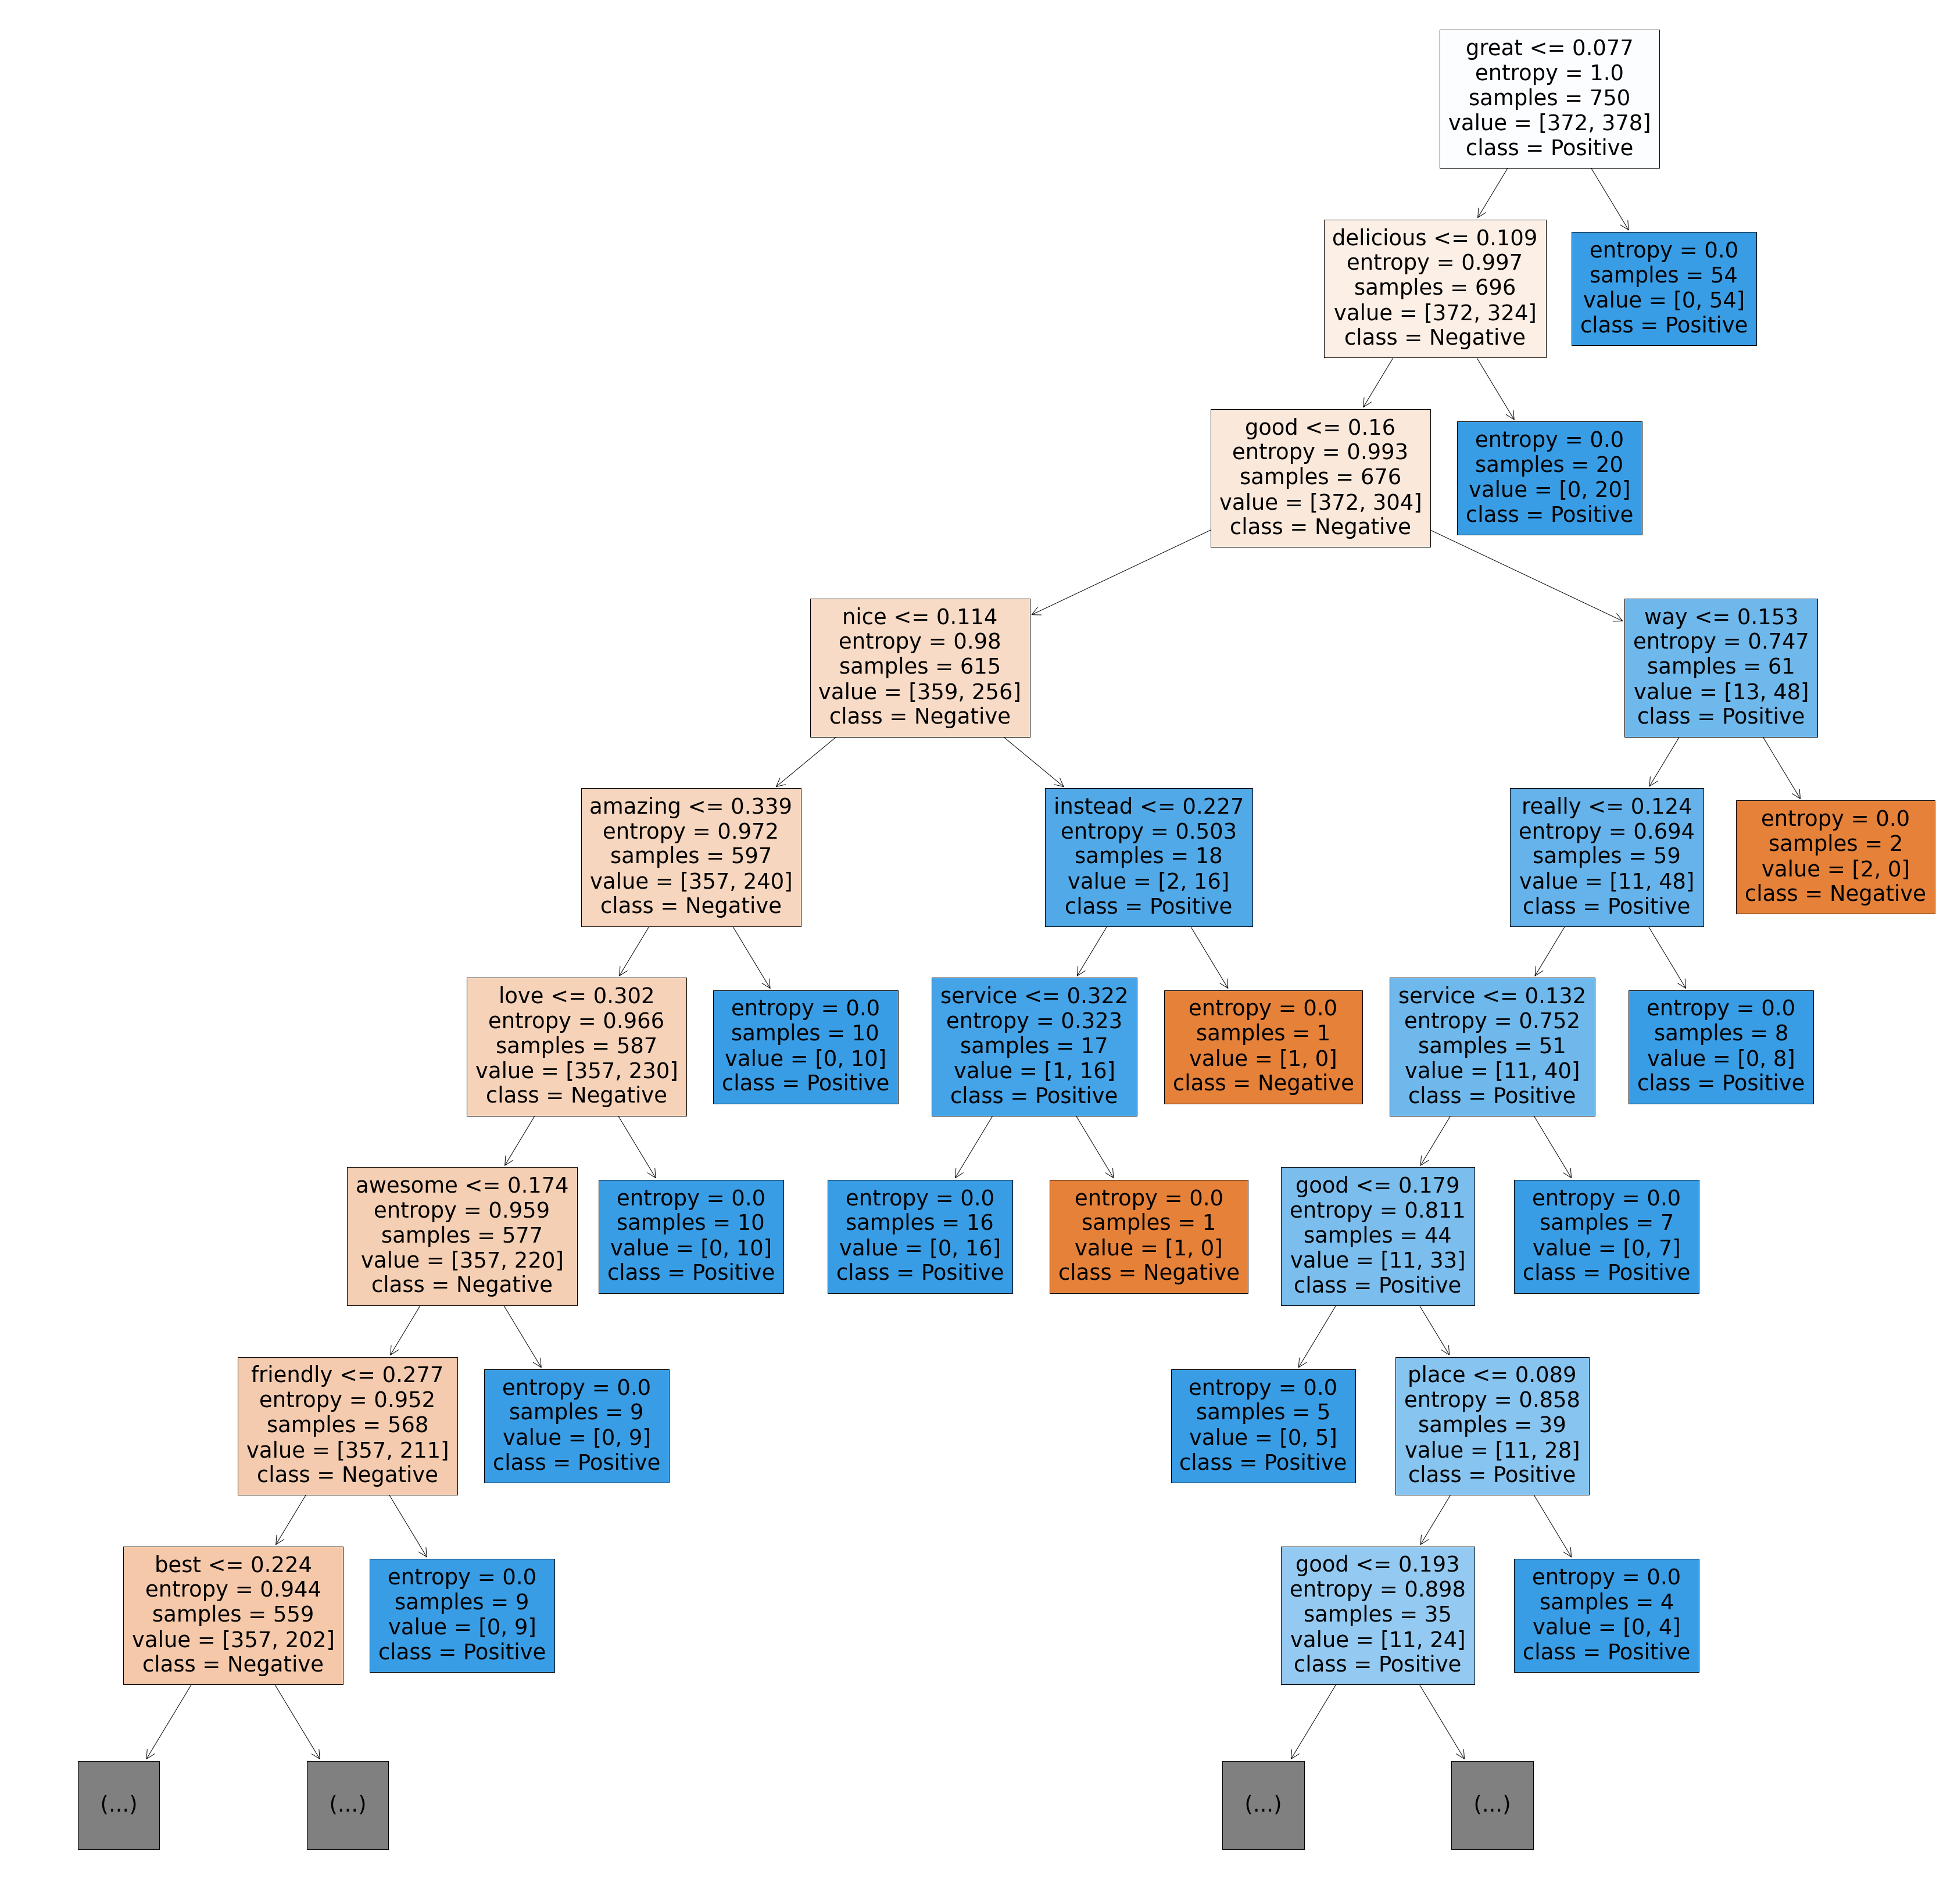

In [ ]:
from sklearn.tree import plot_tree

vectorizer = TfidfVectorizer(stop_words='english', binary='false', ngram_range=(1,1), **default_vectorizer_params)
vdtrain = vectorizer.fit_transform(train.review)
vdtest = vectorizer.transform(test.review)

# tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_LEAF_NODES)
tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=MAX_DEPTH)
tree_classifier.fit(vdtrain, train.valoration)

fig, ax = plt.subplots(figsize=(60, 60))
plot_tree(tree_classifier, ax=ax, max_depth=8, filled=True, class_names=["Negative", "Positive"], feature_names=vectorizer.get_feature_names())

El árbol, al haber limitado su altura máxima, tiene una gran cantidad de nodos hoja. Las palabras más discriminantes parecen ser positivas (great, delicious, good...). Por lo que podemos ver en la rama izquierda, parece identificar las clases negativas por "descarte" (si no aparece nice, ni amazing, ni love, ni awesome, ni friendly, ni best...). Parece ser una buena estrategia pues tiene una alta tasa de aciertos. La parte derecha parece identificar todo como positivo, pero suponemos que más allá de la altura 8 habrá algún nodo negativo.
Sí parece haber nodos impuros que clasifican como negativa a mensajes que podrían ser positivos, razón por la que tan pocas reviews positivas son clasificadas correctamente.

## Errores del Clasificador

### Naive Bayes

Primero imprimiremos los mensajes en los que se haya equivocado el clasificador, para luego dividir entre falsos positivos y falsos negativos

In [ ]:
def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    
    mask=vector_data[index,:]>0
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    if data:
        print('Mensaje', index, ':', data[index])
    
    print('Mensaje', index, 'vectorizado:', terminos.compressed())


vectorizer = TfidfVectorizer(binary='false', ngram_range=(1,2), **default_vectorizer_params)
vdtrain = vectorizer.fit_transform(train.review)
vdtest = vectorizer.transform(test.review)

nb_classifier = MultinomialNB()
nb_classifier.fit(vdtrain, train.valoration)

test_predictions = nb_classifier.predict(vdtest)

#--------Buscamos todos los comentarios que han sido predichos como positivos por el clasificador:
for i,(val,pre) in enumerate(zip(test.valoration, test_predictions)):
    if val == 0 and pre == 1:
        print(f'i: {i:3}, FP predict: {pre}, valoration: {val}')
    elif val == 1 and pre == 0:
        print(f'i: {i:3}, FN predict: {pre}, valoration: {val}')

i:   0, FN predict: 0, valoration: 1
i:  12, FP predict: 1, valoration: 0
i:  16, FN predict: 0, valoration: 1
i:  18, FP predict: 1, valoration: 0
i:  22, FP predict: 1, valoration: 0
i:  26, FN predict: 0, valoration: 1
i:  28, FP predict: 1, valoration: 0
i:  30, FN predict: 0, valoration: 1
i:  40, FP predict: 1, valoration: 0
i:  45, FN predict: 0, valoration: 1
i:  51, FP predict: 1, valoration: 0
i:  52, FP predict: 1, valoration: 0
i:  55, FN predict: 0, valoration: 1
i:  64, FN predict: 0, valoration: 1
i:  68, FN predict: 0, valoration: 1
i:  71, FN predict: 0, valoration: 1
i:  78, FP predict: 1, valoration: 0
i:  85, FP predict: 1, valoration: 0
i:  92, FP predict: 1, valoration: 0
i:  93, FP predict: 1, valoration: 0
i:  94, FN predict: 0, valoration: 1
i: 105, FP predict: 1, valoration: 0
i: 106, FP predict: 1, valoration: 0
i: 107, FP predict: 1, valoration: 0
i: 112, FP predict: 1, valoration: 0
i: 121, FN predict: 0, valoration: 1
i: 125, FN predict: 0, valoration: 1
i

In [ ]:
#Elegimos dos de las reviews que vemos en la lista superior que son, en 
#realidad, negativas (positivos falsos): 

def print_review_info(n, vectorizer, predictions):
    print(test.iloc[n].review)
    print(f'True valoration: {test.iloc[n].valoration}, Predicted: {predictions[n]}')
    write_terms(vectorizer.get_feature_names(), None, vdtest, n)
    print('-------------------------')

print_review_info(18, vectorizer, test_predictions)
print_review_info(52, vectorizer, test_predictions)

The place was not clean and the food oh so stale!
True valoration: 0, Predicted: 1
Mensaje 18 vectorizado: ['clean' 'clean food' 'food' 'oh' 'place' 'stale']
-------------------------
I have been in more than a few bars in Vegas, and do not ever recall being charged for tap water.
True valoration: 0, Predicted: 1
Mensaje 52 vectorizado: ['tap' 'vegas' 'water']
-------------------------


En la primera valoración, podemos ver que se ha vectorizado "clean" y "clean food", pero TF/IDF debe haber eliminado "not clean". "Oh" puede aparecer en muchas reseñas positivas ("Oh my god it was delicious"), por lo que la única palabra con un sentimiento negativo fuerte parece ser "stale", pero tal vez no aparezca las suficientes veces en el corpus como para clasificarla como mala.

Ocurre lo mismo con la segunda valoración. La palabra "vegas", al igual que la palabra "clean", aparece muchas veces en valoraciones positivas, por lo que nuestro clasificador se volvió a equivocar.

In [ ]:
print_review_info(16, vectorizer, test_predictions)
print_review_info(45, vectorizer, test_predictions)

I went to Bachi Burger on a friend's recommendation and was not disappointed.
True valoration: 1, Predicted: 0
Mensaje 16 vectorizado: ['burger' 'disappointed' "friend's" 'recommendation' 'went']
-------------------------
The goat taco didn't skimp on the meat and wow what FLAVOR!
True valoration: 1, Predicted: 0
Mensaje 45 vectorizado: ["didn't" 'flavor' 'meat' 'taco' 'wow']
-------------------------


En el primer mensaje, vemos que está la palabra "disappointed", palabra con gran frecuencia en valoraciones negativas, y que no parece tener nada de influencia en la clase "positivo", por lo que el clasificador, al encontrarse con esta palabra en la valoración, dijo que este mensaje es negativo.

En el segundo mensaje también encontramos palabras negativas como "didn't". ELl resto de palabras no tienen la suficiente "positividad" como para que el clasificador considere todo el mensaje una review positiva.

### Árbol
Volvemos a imprimir todas las veces que el clasificador se ha equivocado

In [ ]:
for i,(val,pre) in enumerate(zip(test.valoration, tree_test_predictions)):
    if val == 0 and pre == 1:
        print(f'i: {i:3}, FP predict: {pre}, valoration: {val}')
    elif val == 1 and pre == 0:
        print(f'i: {i:3}, FN predict: {pre}, valoration: {val}')

i:   0, FN predict: 0, valoration: 1
i:   2, FN predict: 0, valoration: 1
i:   4, FN predict: 0, valoration: 1
i:   7, FN predict: 0, valoration: 1
i:   9, FN predict: 0, valoration: 1
i:  13, FP predict: 1, valoration: 0
i:  16, FN predict: 0, valoration: 1
i:  19, FN predict: 0, valoration: 1
i:  23, FN predict: 0, valoration: 1
i:  30, FN predict: 0, valoration: 1
i:  33, FN predict: 0, valoration: 1
i:  38, FN predict: 0, valoration: 1
i:  41, FN predict: 0, valoration: 1
i:  45, FN predict: 0, valoration: 1
i:  48, FN predict: 0, valoration: 1
i:  51, FP predict: 1, valoration: 0
i:  52, FP predict: 1, valoration: 0
i:  54, FN predict: 0, valoration: 1
i:  55, FN predict: 0, valoration: 1
i:  57, FN predict: 0, valoration: 1
i:  61, FN predict: 0, valoration: 1
i:  62, FN predict: 0, valoration: 1
i:  63, FN predict: 0, valoration: 1
i:  64, FN predict: 0, valoration: 1
i:  65, FN predict: 0, valoration: 1
i:  68, FN predict: 0, valoration: 1
i:  70, FN predict: 0, valoration: 1
i

In [ ]:
#FALSOS POSITIVOS
print_review_info(13, vectorizer, tree_test_predictions)
print_review_info(106, vectorizer, tree_test_predictions)

The food wasn't good.
True valoration: 0, Predicted: 1
Mensaje 13 vectorizado: ['food' 'good' "wasn't"]
-------------------------
However, my recent experience at this particular location was not so good.
True valoration: 0, Predicted: 1
Mensaje 106 vectorizado: ['experience' 'good' 'location']
-------------------------


En ambas valoraciones que presentamos aquí, podemos observar lo mismo que dijimos hace pocas celdas: Tenemos la palabra "good" presente en ambas valoraciones, y al ser la palabra con mayor presencia en la clase positiva, nos encontramos con estos dos falsos positivos. 



In [ ]:
#FALSOS NEGATIVOS
print_review_info(23, vectorizer, tree_test_predictions)
print_review_info(132, vectorizer, tree_test_predictions)

Be sure to order dessert, even if you need to pack it to-go - the tiramisu and cannoli are both to die for.
True valoration: 1, Predicted: 0
Mensaje 23 vectorizado: ['dessert' 'need' 'order' 'sure']
-------------------------
Plus, it's only 8 bucks.
True valoration: 1, Predicted: 0
Mensaje 132 vectorizado: ['bucks' "it's"]
-------------------------
Plus, it's only 8 bucks.
True valoration: 1, Predicted: 0
Mensaje 132 vectorizado: ['bucks' "it's"]
-------------------------


Ninguna de estas dos valoraciones tienen palabras que indiquen un sentimiento concreto, y como hemos visto antes, la ambigüedad de las palabras puede llegar a fallos en el clasificador. La primera se podría haber clasificado con el trigrama "to die for", una expresión que indica que algo es tan bueno como para morir por ello. En la segunda, el monograma "plus" tampoco se ha reconocido.

Si quisiéramos mejorar los clasificadores, podríamos aumentar la complejidad, es decir, en vez de usar bigramas, usar un n mayor para los n-gramas, mejorar el diccionario de las stop words y conseguir un conjunto más grande de entrenamiento. 